# Intro
Predict Vertices position for Ellipses.

In [1]:
### Load packages
from IPython.display import display, Image
import PIL
import imageio
from scipy import ndimage, misc
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import os
import sys
from pathlib import Path

from six.moves import cPickle as pickle

import numpy as np
import imageio

In [2]:
# More packages
from shapely.geometry import Polygon
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from tensorflow.keras.utils import to_categorical, Sequence 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


# Our modules
from mix_module.shape_utils import find_nearest_index, select_first_vertice_index2, find_lefmost_index_in_subrect, select_first_vertice_index, sort_vertices_clockwize, cart2pol, pol2cart, calculate_Dice, PixtoDataGenerator  
from mix_module.utils import ShowBestEpochResult

import datetime
datetime.datetime.now()

datetime.datetime(2022, 5, 1, 20, 49, 34, 316455)

In [3]:
# GPU Setting
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from platform import python_version
print(python_version())

3.8.5


In [5]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [6]:
seed1=127
np.random.seed(seed1)

## Define environment variables

In [7]:
BASEDIR = ".."

DATADIR = os.path.join(BASEDIR, "pickles")

TRAIN_DATAFILE = os.path.join(DATADIR, 'train_ell.pickle')
VAL_DATAFILE   = os.path.join(DATADIR, 'val_ell.pickle')
TEST_DATAFILE  = os.path.join(DATADIR, 'test_ell.pickle')

MODEL_DIR      = os.path.join(BASEDIR, "saved_models")
model_name     = os.path.join(MODEL_DIR, "ellipse1.model") 

In [8]:
# Set image properties
image_size  = 70     # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [9]:
# Create model directory
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

## Load train, validation and test datasets from Pickles

In [10]:
with open(TRAIN_DATAFILE, 'rb') as f:
    train_dict = pickle.load(f)
with open(VAL_DATAFILE, 'rb') as f:
    val_dict = pickle.load(f)
with open(TEST_DATAFILE, 'rb') as f:
    test_dict = pickle.load(f)

In [11]:
## Construct train set
train_X = train_dict['train_data']
train_y = train_dict['train_labels']

In [12]:
## Construct validation set
val_X = val_dict['val_data']
val_y = val_dict['val_labels']

In [13]:
print("train_X shape: ", train_X.shape)
print("train_y shape: ", train_y.shape)

train_X shape:  (4828, 70, 70)
train_y shape:  (4828, 8)


In [14]:
print("val_X shape: ", val_X.shape)
print("val_y shape: ", val_y.shape)

val_X shape:  (1446, 70, 70)
val_y shape:  (1446, 8)


In [15]:
# Reshape image in 3 dimensions (height = 70px, width = 70px , canal = 1)
X_train = train_X.reshape(-1, image_size,image_size, 1)
X_val   = val_X.reshape(-1, image_size,image_size, 1)

In [16]:
Y_train = train_y
Y_val = val_y

In [17]:
X_train.shape

(4828, 70, 70, 1)

In [18]:
X_val.shape

(1446, 70, 70, 1)

In [19]:
Y_train.shape

(4828, 8)

In [20]:
Y_val.shape

(1446, 8)

In [21]:
# Labels are vertices: x1, y1, x2, y2, x3, y3, x4, y4
# Where:
# - (0, 0) is the top left corner of the image
# - (1, 1) is the bottom right corner of the image
print("Real Label example: ", Y_val[0])

Real Label example:  [0.42 0.49 0.51 0.12 0.58 0.5  0.48 0.87]


In [22]:
# TODO Show the corresponding image with superimposed vertices.

In [23]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [24]:
def plot_sample(X, y, axs):
    axs.imshow(X.reshape(image_size, image_size), cmap="gray") # Put the Image
    y = y.ravel()
    axs.scatter(image_size * y[0::2], image_size * y[1::2], c='orange') # Add the labels as orange dots

In [25]:
# This function shows images with their real vertices
# Presentation is 5 rows of 10 images
def display_50_images_with_vertices(X, Y):

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1.5)

    nb_pictures = 50
    for i_pic in range(nb_pictures):
        x = X[i_pic]
        y = Y[i_pic]

        ax  = fig.add_subplot(nb_pictures//5, 10, i_pic + 1, xticks=[], yticks=[])
        plot_sample(x, y, ax)
    plt.show()

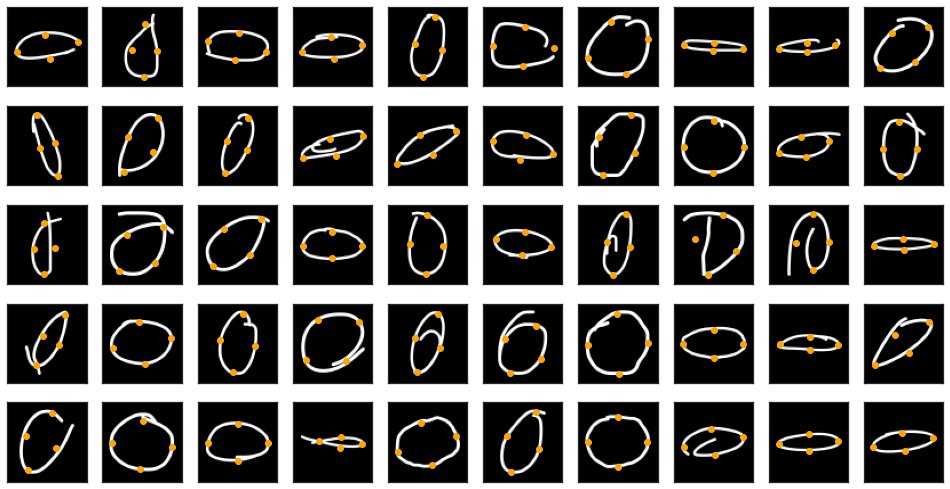

In [26]:
# Show random images from the Train Set + superimposed vertices
indexes = np.arange(len(Y_train))
np.random.shuffle(indexes)
first_random_indexes = indexes[:50]

display_50_images_with_vertices(X_train[first_random_indexes], Y_train[first_random_indexes])

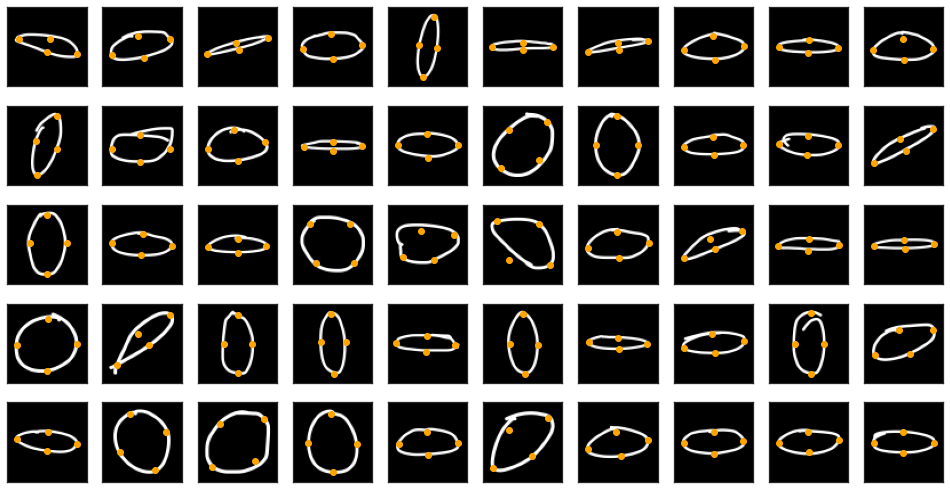

In [27]:
# Show random images from the Validation Set + superimposed vertices
indexes = np.arange(len(Y_val))
np.random.shuffle(indexes)
first_random_indexes = indexes[:50]

display_50_images_with_vertices(X_val[first_random_indexes], Y_val[first_random_indexes])

In [28]:
tf.keras.backend.clear_session()

## Define Deep Learning Model

In [29]:
def get_model_cnn():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.05)(x)

    x = Flatten()(x)
    x = Dense(200)(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(8)(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [30]:
# select a model
model = get_model_cnn()

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 70, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 70, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 32)       

## Data augmentation: Full rotation, Flip vert. and Horiz with Targets modified

In [31]:
# Partition for the Generator
partition = []

nb_samples = X_train.shape[0]
print("nb_samples: ", nb_samples)

for i in range(nb_samples):
    partition.append(i)

nb_samples:  4828


In [32]:
batch_size = 128
pixto_gen = PixtoDataGenerator(partition, X_train, Y_train, batch_size=batch_size, n_vertices=4, x_pos=0.0, y_pos=0.65)
# TODO:
# - Explain PixtoDataGenerator. This is improved and more complex version of my generator
#   described at: https://github.com/frobertpixto/tf_keras_generator_with_targets
# - Explain x_pos=0.0, y_pos=0.65 that must match ETL


## Define the optimizer

In [33]:
optimizer = Adam(lr=4e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

# Compile the model

In [34]:
model.compile(optimizer = optimizer , loss = "mean_squared_error")

# Set a learning rate callback

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=25,
                                            verbose=1,
                                            factor=0.90, 
                                            mode='min',
                                            min_delta=0.0000001,
                                            min_lr=0.000000001)


# Fit the model with data Augmentation

In [36]:
# I like to start a few epoch with a small batch size because:
# - This basically makes the learning rate larger. https://openreview.net/pdf?id=B1Yy1BxCZ#:~:text=Increasing%20the%20batch%20size%20during%20training%20achieves%20similar%20results%20to,twice%20to%20illustrate%20the%20variance.
# - This covers to 0 to 80% of the accuracy/loss curve, cleaning the graphs
epochs = 6
history = model.fit(x=pixto_gen,
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/6
37/37 [==============================] - 6s 156ms/step - loss: 0.2331 - val_loss: 0.1954
Epoch 2/6
37/37 [==============================] - 6s 161ms/step - loss: 0.0392 - val_loss: 0.1504
Epoch 3/6
37/37 [==============================] - 6s 157ms/step - loss: 0.0242 - val_loss: 0.0988
Epoch 4/6
37/37 [==============================] - 6s 156ms/step - loss: 0.0190 - val_loss: 0.0869
Epoch 5/6
37/37 [==============================] - 6s 153ms/step - loss: 0.0154 - val_loss: 0.0599
Epoch 6/6
37/37 [==============================] - 6s 153ms/step - loss: 0.0131 - val_loss: 0.0383


In [37]:
# Fit and Save the Best model
h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_loss', verbose=1, save_best_only=True)

best_epoch_results = ShowBestEpochResult(on_param='val_loss', show_params=['val_loss', 'loss'], mode='min')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs  = 200 #1100
history = model.fit(x=pixto_gen,
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

Epoch 1/200
37/37 [==============================] - ETA: 0s - loss: 0.0123
Epoch 00001: val_loss improved from inf to 0.03647, saving model to ../saved_models/ellipse1.model.h5
37/37 [==============================] - 6s 158ms/step - loss: 0.0123 - val_loss: 0.0365
Epoch 2/200
37/37 [==============================] - ETA: 0s - loss: 0.0110
Epoch 00002: val_loss improved from 0.03647 to 0.03003, saving model to ../saved_models/ellipse1.model.h5
37/37 [==============================] - 6s 159ms/step - loss: 0.0110 - val_loss: 0.0300
Epoch 3/200
37/37 [==============================] - ETA: 0s - loss: 0.0106
Epoch 00003: val_loss improved from 0.03003 to 0.02602, saving model to ../saved_models/ellipse1.model.h5
37/37 [==============================] - 6s 157ms/step - loss: 0.0106 - val_loss: 0.0260
Epoch 4/200
37/37 [==============================] - ETA: 0s - loss: 0.0093
Epoch 00004: val_loss improved from 0.02602 to 0.01877, saving model to ../saved_models/ellipse1.model.h5
37/37 [==

Epoch 34/200
37/37 [==============================] - ETA: 0s - loss: 0.0049
Epoch 00034: val_loss did not improve from 0.00241
37/37 [==============================] - 6s 158ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 35/200
37/37 [==============================] - ETA: 0s - loss: 0.0050
Epoch 00035: val_loss did not improve from 0.00241
37/37 [==============================] - 6s 157ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 36/200
37/37 [==============================] - ETA: 0s - loss: 0.0051
Epoch 00036: val_loss improved from 0.00241 to 0.00240, saving model to ../saved_models/ellipse1.model.h5
37/37 [==============================] - 6s 155ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 37/200
37/37 [==============================] - ETA: 0s - loss: 0.0048
Epoch 00037: val_loss did not improve from 0.00240
37/37 [==============================] - 6s 155ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 38/200
37/37 [==============================] - ETA: 0s - loss: 0.0052


Epoch 70/200
37/37 [==============================] - ETA: 0s - loss: 0.0039
Epoch 00070: val_loss did not improve from 0.00195
37/37 [==============================] - 6s 152ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 71/200
37/37 [==============================] - ETA: 0s - loss: 0.0041
Epoch 00071: val_loss did not improve from 0.00195
37/37 [==============================] - 6s 152ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 72/200
37/37 [==============================] - ETA: 0s - loss: 0.0040
Epoch 00072: val_loss did not improve from 0.00195
37/37 [==============================] - 6s 153ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 73/200
37/37 [==============================] - ETA: 0s - loss: 0.0037
Epoch 00073: val_loss did not improve from 0.00195
37/37 [==============================] - 6s 156ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 74/200
37/37 [==============================] - ETA: 0s - loss: 0.0039
Epoch 00074: val_loss did not improve from 0.00195
37/3

Epoch 108/200
37/37 [==============================] - ETA: 0s - loss: 0.0035
Epoch 00108: val_loss did not improve from 0.00179
37/37 [==============================] - 6s 154ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 109/200
37/37 [==============================] - ETA: 0s - loss: 0.0035
Epoch 00109: val_loss did not improve from 0.00179
37/37 [==============================] - 6s 154ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 110/200
37/37 [==============================] - ETA: 0s - loss: 0.0034
Epoch 00110: val_loss did not improve from 0.00179
37/37 [==============================] - 6s 151ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 111/200
37/37 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00111: val_loss did not improve from 0.00179
37/37 [==============================] - 6s 151ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 112/200
37/37 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00112: ReduceLROnPlateau reducing learning r

Epoch 145/200
37/37 [==============================] - ETA: 0s - loss: 0.0029
Epoch 00145: val_loss did not improve from 0.00174
37/37 [==============================] - 6s 151ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 146/200
37/37 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00146: val_loss did not improve from 0.00174
37/37 [==============================] - 6s 152ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 147/200
37/37 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00147: val_loss improved from 0.00174 to 0.00165, saving model to ../saved_models/ellipse1.model.h5
37/37 [==============================] - 6s 155ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 148/200
37/37 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00148: val_loss did not improve from 0.00165
37/37 [==============================] - 6s 154ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 149/200
37/37 [==============================] - ETA: 0s - loss: 0.

Epoch 182/200
37/37 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00182: val_loss did not improve from 0.00165
37/37 [==============================] - 6s 152ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 183/200
37/37 [==============================] - ETA: 0s - loss: 0.0029
Epoch 00183: val_loss did not improve from 0.00165
37/37 [==============================] - 6s 154ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 184/200
37/37 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00184: val_loss did not improve from 0.00165
37/37 [==============================] - 6s 155ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 185/200
37/37 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00185: val_loss did not improve from 0.00165
37/37 [==============================] - 6s 153ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 186/200
37/37 [==============================] - ETA: 0s - loss: 0.0030
Epoch 00186: val_loss did not improve from 0.00165

## Plot the loss curves for training and validation

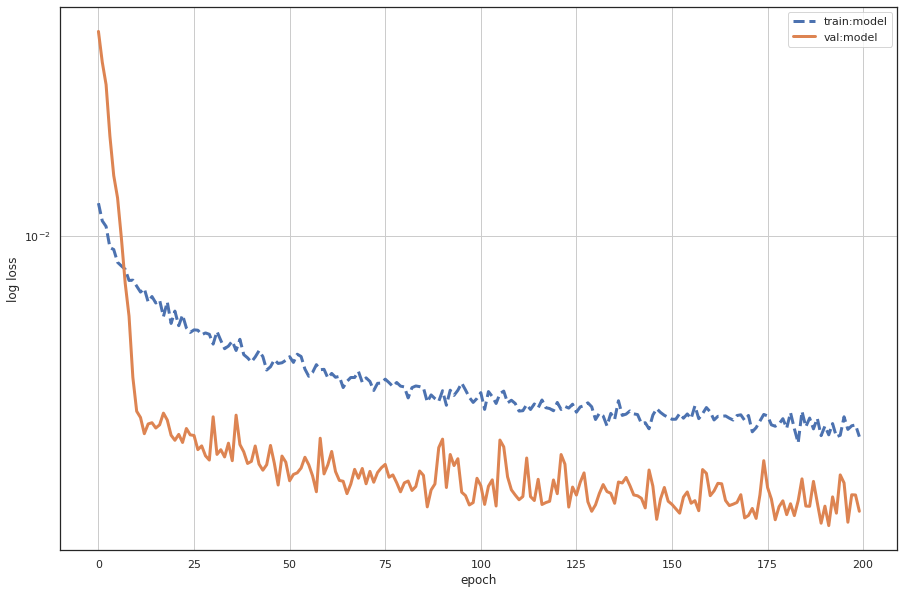

In [38]:
plt.figure(figsize=(15,10))
plot_loss(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

## Delete the existing model + Load the best one

In [39]:
# deletes the existing model
del model

# Load last saved model
model = load_model(model_name + ".h5")

In [40]:
Y_val_pred = model.predict(X_val)

In [41]:
# Labels are vertices: x1, y1, x2, y2, x3, y3, y4, y4
# Where:
# - (0, 0) is the top left corner of the image
# - (1, 1) is the bottom right corner of the image
print("Y_val shape: ", Y_val.shape)
print("Y_val_pred shape: ", Y_val_pred.shape)
print("Real Label example: ", Y_val[0])
print("Prediction example: ", Y_val_pred[0])

Y_val shape:  (1446, 8)
Y_val_pred shape:  (1446, 8)
Real Label example:  [0.42 0.49 0.51 0.12 0.58 0.5  0.48 0.87]
Prediction example:  [0.40389118 0.47491255 0.5042391  0.11077122 0.59255886 0.5285092
 0.47770455 0.8949884 ]


# Calculate Dice accuracy for the whole Validation set

In [42]:
nb_samples = Y_val.shape[0]
dice_sum = 0.0
for i in range(nb_samples):
    dice = calculate_Dice(Y_val[i], Y_val_pred[i], nb_vertices=4)
    dice_sum += dice
    
dice_val = dice_sum / nb_samples
print(f"Validation Accuracy(Dice): {dice_val}.")

Validation Accuracy(Dice): 0.8937295342919955.


In [43]:
def plot_sample_with_pred(X, y, pred,axs):
   
    axs.imshow(X.reshape(image_size, image_size),cmap="gray") # Shape
    axs.scatter(image_size*y[0::2], image_size*y[1::2],c='orange') # Real Vertices
    axs.scatter(image_size*pred[0::2], image_size*pred[1::2],c='green') # Predicted Vertices

# Validation set predictions - Visualization

<ipython-input-44-58e9a55e90ba>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])


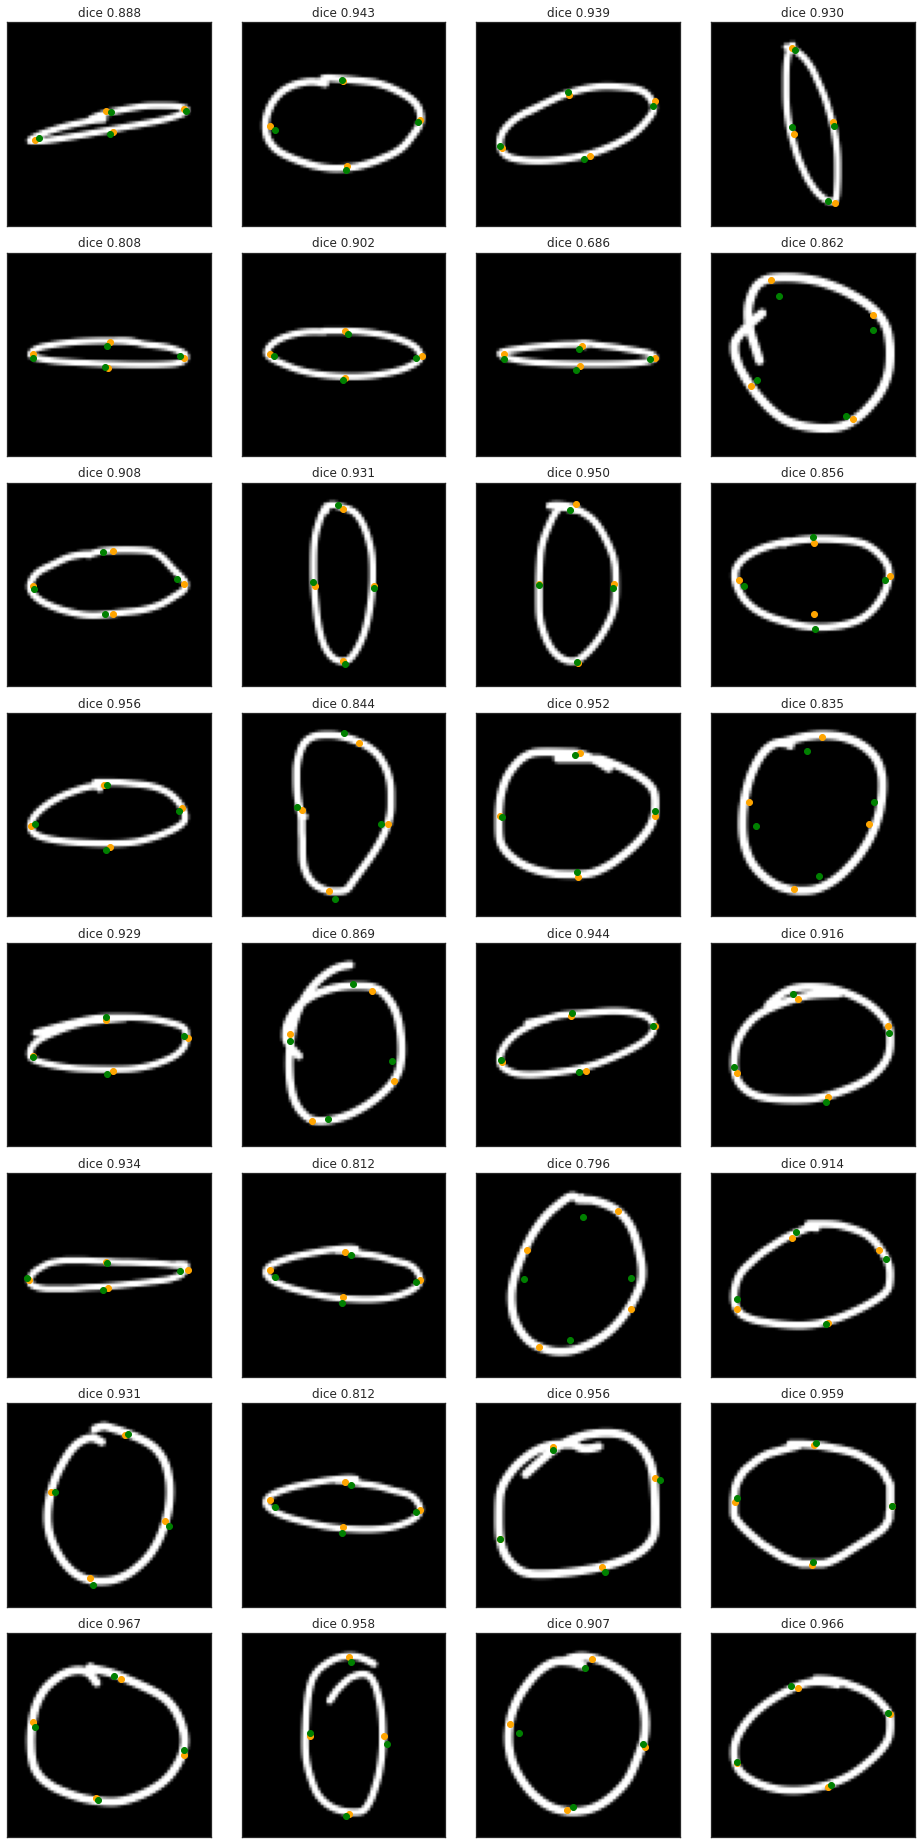

In [44]:
fig = plt.figure(figsize=(13, 21))
fig.subplots_adjust(hspace=0.13, wspace=0.01,
                    left=0, right=1, bottom=0, top=1.2)
nb_pictures = 32
count = 1
for irow in range(nb_pictures):
    ipic = np.random.choice(X_val.shape[0])
    ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])        
    plot_sample_with_pred(X_val[ipic], Y_val[ipic], Y_val_pred[ipic], ax)

    dice = calculate_Dice(Y_val[ipic], Y_val_pred[ipic], nb_vertices=4)
    ax.set_title("dice {:5.3f}".format(dice))
    count += 1
plt.show()

In [45]:
#TODO Display the 32 worst RMSE images

## Predict for the test set

In [46]:
## Prepare the Test set
test_X = test_dict['test_data']
test_y = test_dict['test_labels']
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test    = test_X.reshape(-1, image_size,image_size, 1)
Y_test    = test_y 
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (180, 70, 70)
test_y shape:  (180, 8)
X_test shape:  (180, 70, 70, 1)
Y_test shape:  (180, 8)


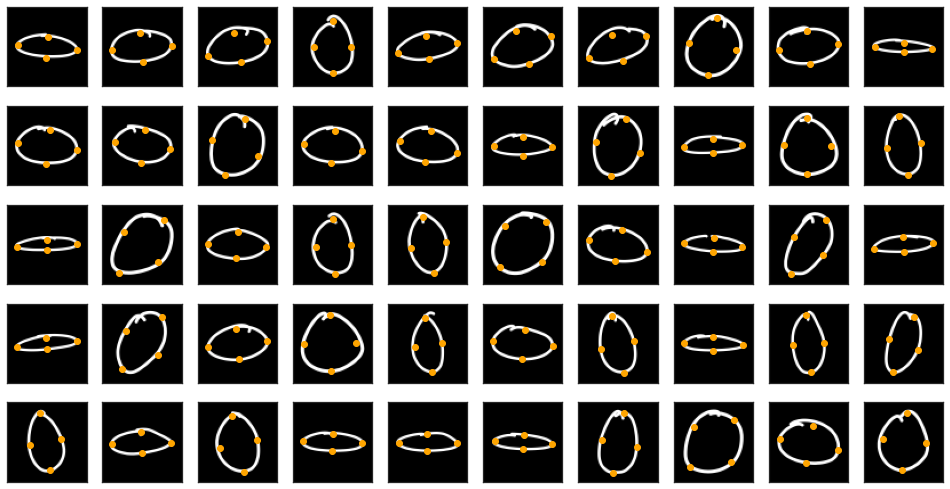

In [47]:
# Show random images from the Test Set + superimposed vertices
indexes = np.arange(len(Y_test))
np.random.shuffle(indexes)
first_random_indexes = indexes[:50]

display_50_images_with_vertices(X_test[first_random_indexes], Y_test[first_random_indexes])

In [48]:
test_loss = model.evaluate(X_test, Y_test)
print("test_loss: ", test_loss)

6/6 [==============================] - 0s 7ms/step - loss: 0.0020
test_loss:  0.0019511673599481583


In [49]:
Y_test_pred = model.predict(X_test)

In [50]:
print("Y_pred shape: ", Y_test_pred.shape)
Y_test_pred[0:2, :]

Y_pred shape:  (180, 8)


array([[0.3046041 , 0.76828563, 0.34420872, 0.313267  , 0.7058518 ,
        0.20475833, 0.671328  , 0.67315364],
       [0.10502812, 0.6100571 , 0.41857904, 0.3028559 , 0.870185  ,
        0.37758106, 0.5410248 , 0.69796824]], dtype=float32)

# Calculate Dice accuracy for the whole Test set

In [51]:
nb_samples = Y_test.shape[0]
dice_sum = 0.0
for i in range(nb_samples):
    dice = calculate_Dice(Y_test[i], Y_test_pred[i], nb_vertices=4)
    dice_sum += dice
    
dice_val = dice_sum / nb_samples
print(f"Validation Accuracy(Dice): {dice_val}.")

Validation Accuracy(Dice): 0.8909205322307261.


# Test set predictions - Visualization

<ipython-input-52-a19916c816e7>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])


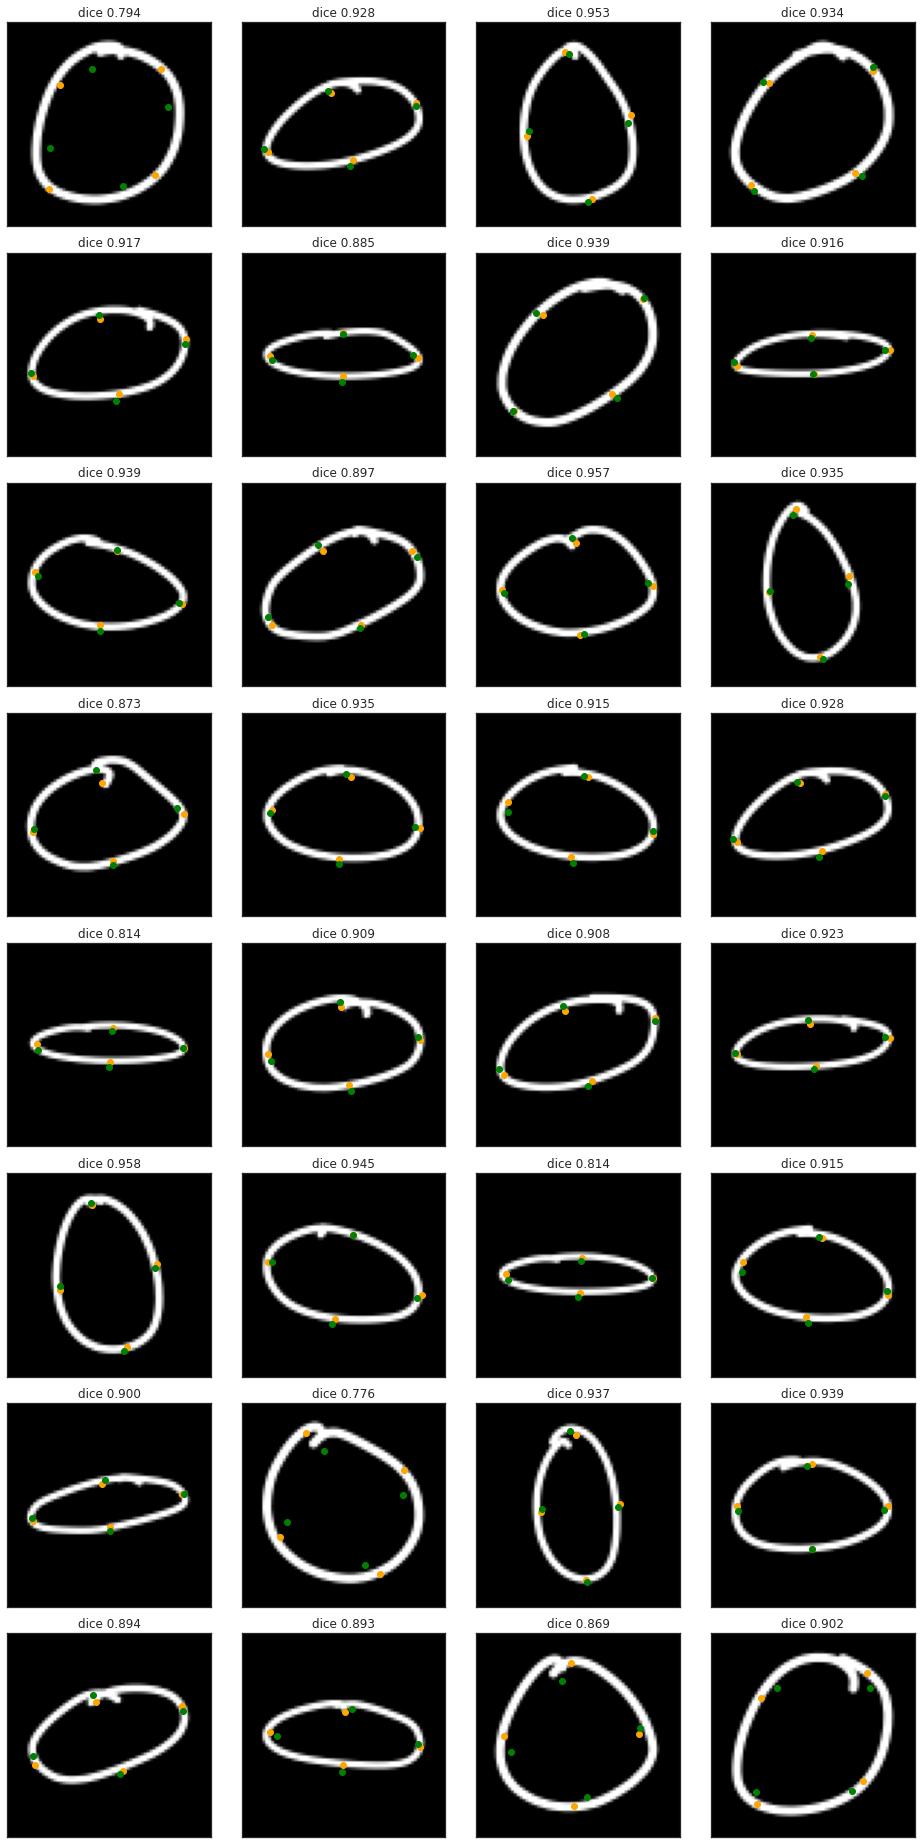

In [52]:
fig = plt.figure(figsize=(13, 21))
fig.subplots_adjust(hspace=0.13, wspace=0.01,
                    left=0, right=1, bottom=0, top=1.2)
nb_pictures = 32
count = 1
for irow in range(nb_pictures):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(nb_pictures/4 , 4, count,xticks=[],yticks=[])        
    plot_sample_with_pred(X_test[ipic], Y_test[ipic], Y_test_pred[ipic], ax)

    dice = calculate_Dice(Y_test[ipic], Y_test_pred[ipic], nb_vertices=4)
    ax.set_title("dice {:5.3f}".format(dice))
    count += 1
plt.show()

# Conclusion
- TODO
- Indicate the accuracy with around 1000 epochs for Mix on Pix

In [53]:
datetime.datetime.now()

datetime.datetime(2022, 5, 1, 21, 10, 2, 707162)